# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,LinearSVC, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from time import time

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Preprocessing Steps

I will perform below steps in the preprocessing part to discover and analyze the dataset in a better way. 

1. Loading the data from json file and make transformation to pandas dataframe.
2. Dealing with missing variables.
    1. Analyzing the variables of columns and removing empty entries, '', in userID.   
    2. Identifying the missing features and removing or replacing them.
3. Converting the timestamp column in more readible way. 
4. Converting gender information to binary variable from Female to Male. 

After performing these steps, *Churn* will be defined according to Cancellation Confirmation feature. In the Churn column, 1 will represent the user has churned and 0 otherwise. 


#### Loading The Data

In [89]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# df.persist()
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Since I am more familiar with pandas dataframe, I will convert the spark object to pandas df.

[1] https://stackoverflow.com/questions/29226210/what-is-the-spark-dataframe-method-topandas-actually-doing

[2] https://www.oreilly.com/library/view/pyspark-cookbook/9781788835367/fe13b699-9b45-4295-a0cb-6375fa98a3e3.xhtml

In [4]:
df_pandas = df.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
# To know nulls
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


#### Dealing With Missing Values

Before proceeding the data cleaning, lets see the NaN values in the dataset columns..

In [6]:
df_pandas.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [7]:
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [8]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [9]:
df_pandas = df.toPandas()

In [10]:
df_pandas.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

It is seen that *FirstName, Gender, LastName, Location, Registration, and UserAgent* have the same number of missing values.

In [11]:
df_pandas['auth'].unique()

array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object)

In [12]:
df_pandas['gender'].unique()

array(['M', 'F', None], dtype=object)

It is seen that we have None values in gender section.

In [13]:
df_pandas['level'].unique()

array(['paid', 'free'], dtype=object)

In [14]:
df_pandas['method'].unique()

array(['PUT', 'GET'], dtype=object)

In [15]:
df_pandas['page'].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
       'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object)

In [16]:
#df_pandas['registration'].unique()
df_pandas['status'].unique()

array([200, 307, 404])

In [17]:
df_pandas['userId'].unique()

array(['30', '9', '74', '54', '', '4', '101', '78', '88', '95', '25',
       '142', '13', '45', '39', '87', '28', '131', '126', '146', '59',
       '15', '36', '120', '92', '33', '51', '27', '143', '140', '6', '124',
       '141', '93', '81', '40', '94', '113', '98', '137', '65', '53', '42',
       '115', '38', '58', '77', '52', '29', '70', '61', '46', '35', '132',
       '127', '136', '80', '110', '129', '121', '82', '100', '117', '18',
       '85', '118', '105', '96', '20', '55', '3', '12', '41', '73', '17',
       '86', '7', '67', '32', '5', '106', '114', '69', '99', '16', '49',
       '50', '24', '103', '102', '122', '75', '135', '128', '111', '112',
       '145', '66', '83', '44', '11', '91', '37', '90', '104', '138',
       '148', '107', '97', '109', '134', '10', '2', '144', '76', '119',
       '89', '14', '62', '19', '150', '68', '147', '8', '56', '34', '60',
       '125', '47', '133', '26', '43', '57', '149', '64', '21', '71',
       '108', '79', '123', '116', '152', '63', '139

It is seen that we have **' '** value as an entry in the dataset. So we can clear them first and then check the None values in the gender section.

In [18]:
df_pandas[df_pandas['userId'] == '']['userId'].count()

8346

Lets check the count in the spark dataframe.

[1] https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html

In [19]:
df.filter(df.userId == '').count()

8346

Next step will be removing the **' '** values in UserId. 

In [20]:
df = df.filter(df.userId != '')

In [21]:
df.filter(df.userId == '').count()

0

In [22]:
df_pandas = df.toPandas()
df_pandas.isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

Let's observe the missing values after the conversion.

In [23]:
df_pandas[df_pandas.isnull().any(axis=1)]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
11,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
14,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
35,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
44,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1532482662000,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
47,None,Logged In,Micah,M,95,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1538331630000,8,None,307,1538355306000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
51,None,Logged In,Micah,M,97,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1538331630000,8,None,200,1538355504000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
53,None,Logged In,Micah,M,99,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1538331630000,8,None,307,1538355687000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
56,None,Logged In,Ashlynn,F,9,Williams,NaN,free,"Tallahassee, FL",PUT,Thumbs Up,1537365219000,217,None,307,1538355711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74
57,None,Logged In,Micah,M,104,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1538331630000,8,None,200,1538355855000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


Since we will make analysis based on Chunk, it is not needed to drop the None values in artist, length, and song column. Because, they indicate that user is logged in but not listening any song yet therefore no length value.

In [24]:
print('Unique values in auth  column : \n{}'.format(df_pandas['auth'].unique()))
print('Unique values in gender  column : \n{}'.format(df_pandas['gender'].unique()))
print('Unique values in level  column : \n{}'.format(df_pandas['level'].unique()))
print('Unique values in method  column : \n{}'.format(df_pandas['method'].unique()))
print('Unique values in page  column : \n{}'.format(df_pandas['page'].unique()))
print('Unique values in status  column : \n{}'.format(df_pandas['status'].unique()))

Unique values in auth  column : 
['Logged In' 'Cancelled']
Unique values in gender  column : 
['M' 'F']
Unique values in level  column : 
['paid' 'free']
Unique values in method  column : 
['PUT' 'GET']
Unique values in page  column : 
['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings'
 'Submit Upgrade' 'About' 'Submit Downgrade' 'Error' 'Save Settings'
 'Cancel' 'Cancellation Confirmation']
Unique values in status  column : 
[200 307 404]


It is seen that after dropping the ' ' values in UserId column, we also clean the FirstName, Gender, LastName, Location, Registration, and UserAgent columns which have the same missing number count as UserId ' ' count.

When we compare the unique values in dataset before and after the cleaning of UserId column, it is seen that we have lost two information in the auth column, Logged out and Guest. Additionaly, in the page column, we do not have Login, Registration, and Submit Registration informations anymore. 

Since we have dropped the *empty* user ıds, it might be logical in the sense of users without userid can be guests or logged out users. It make sense for page column also because the lost informations are related to guest users and logged out users.

It is also logical that we have lost None values in gender column, because guest users or logged out users do not have gender information. 



#### Converting The Timestamp

[1] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

[2] https://stackoverflow.com/questions/13890935/does-pythons-time-time-return-the-local-or-utc-timestamp

[3] https://stackoverflow.com/questions/2265357/parse-date-string-and-change-format

In [25]:
df_pandas['ts'].head()

0    1538352117000
1    1538352180000
2    1538352394000
3    1538352416000
4    1538352676000
Name: ts, dtype: int64

In [26]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In order to use Python function in Spark, I have used udf.

[1] https://changhsinlee.com/pyspark-udf/

[2] https://docs.databricks.com/spark/latest/spark-sql/udf-python.html

In [27]:
df_pandas = df.toPandas()

In [28]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16


Since the registration column is also in timestamp format, I will perform the same conversion of ts column for registration column.

In [29]:
df = df.withColumn('registration_time', get_time(df.registration))

In [30]:
df_pandas = df.toPandas()

In [31]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time,registration_time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,2018-09-28 22:22:42
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,2018-09-30 18:20:30
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,2018-09-28 22:22:42
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,2018-09-30 18:20:30
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,2018-09-28 22:22:42


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

Customer churn occurs when customers/subscribers stop doing business with a company or service. We can define a user as churned if there is an Cancellation Confirmation event. And Churn is defined both free and paid users. In order to track the downgrade event of a paid user can also be sight about customer churn.


[1] https://blog.recurly.com/better-way-to-calculate-your-churn-rate


First look for cancellation confirmation events to define Churn.

In [32]:
# create churn label
flag_cancellation = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Apply it to the dataframe
df = df.withColumn('churn', flag_cancellation('page'))

# label user who churned
windowval = Window.partitionBy('userId')

# Apply it to the dataframe
df = df.withColumn('churn', max('churn').over(windowval))

In [33]:
df_pandas = df.toPandas()

Now, look for downgrade events.

In [34]:
# create downgrade label
flag_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

# Apply it to the dataframe
df = df.withColumn("downgrade", flag_downgrade("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')

# Apply it to the dataframe
df = df.withColumn('downgrade', max('downgrade').over(windowval))

In [35]:
df_pandas = df.toPandas()

In [36]:
df_pandas.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,time,registration_time,churn,downgrade
185153,Jamie T,Logged In,Daniel,M,161,Marks,259.65669,paid,"Chicago-Naperville-Elgin, IL-IN-WI",PUT,...,94,Sheila (Explicit),200,1539972314000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100012,2018-10-19 18:05:14,2018-09-19 18:19:14,1,1
12368,Energy 52,Logged In,Alexi,F,30,Warren,462.13179,free,"Spokane-Spokane Valley, WA",PUT,...,963,CafÃÂ© Del Mar,200,1539789477000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,2018-10-17 15:17:57,2018-07-25 01:37:42,1,1
178657,P.O.D.,Logged In,Erick,M,153,Brooks,258.16771,paid,"Selma, AL",PUT,...,1069,Youth Of The Nation (2006 Remastered Album Ver...,200,1540023127000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",58,2018-10-20 08:12:07,2018-09-26 10:12:31,1,0
190882,DJ Khaled,Logged In,Kaylenn,F,82,Jenkins,227.08200,paid,"Price, UT",PUT,...,649,All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop...,200,1540054668000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",141,2018-10-20 16:57:48,2018-09-02 15:57:58,0,1
256047,LMFAO,Logged In,Anika,F,10,Osborne,227.99628,free,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",PUT,...,1262,I'm In Miami Bitch,200,1540478927000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",13,2018-10-25 14:48:47,2018-08-02 06:40:32,0,1


Let's observe the spark dataframe

In [37]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [38]:
df.select(['userId', 'churn', 'downgrade']).dropDuplicates().show(20)

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    0|        0|
|200002|    0|        0|
|   125|    1|        0|
|   124|    0|        0|
|    51|    1|        0|
|     7|    0|        0|
|    15|    0|        0|
|    54|    1|        1|
|   155|    0|        0|
|100014|    1|        0|
|   132|    0|        0|
|   154|    0|        0|
|   101|    1|        0|
|    11|    0|        1|
|   138|    0|        0|
|300017|    0|        0|
|100021|    1|        0|
|    29|    1|        0|
|    69|    0|        0|
|   112|    0|        0|
+------+-----+---------+
only showing top 20 rows



Now we have defined **churn** and **downgrade** events as seperate columns.


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

##### Gender distribution on churn event

First, we can explore the gender distribution on churn event to understand gender has an effect or not.

[1] https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

In [39]:
df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [40]:
df_pandas_gender = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

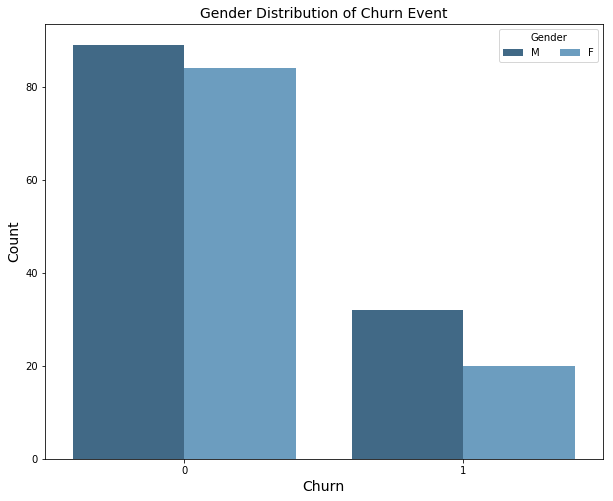

In [41]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'churn', y = 'count', hue = 'gender', data = df_pandas_gender,  palette = "Blues_d")
plt.xlabel('Churn', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(title = 'Gender', loc = 'best', ncol = 2)

plot = plt.title('Gender Distribution of Churn Event', fontsize = 14)


It is seen that male customers are slightly like to be churn than the female users. 

##### Number of played/listened songs

It might be a good indicator to understand the number of played songs in a session among the genders. Therefore, we may see the reason of male users have more likely to be churned.

[1] https://www.datacamp.com/community/blog/seaborn-cheat-sheet-python

[2] https://seaborn.pydata.org/generated/seaborn.violinplot.html

In [42]:
df_pandas_song = df.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

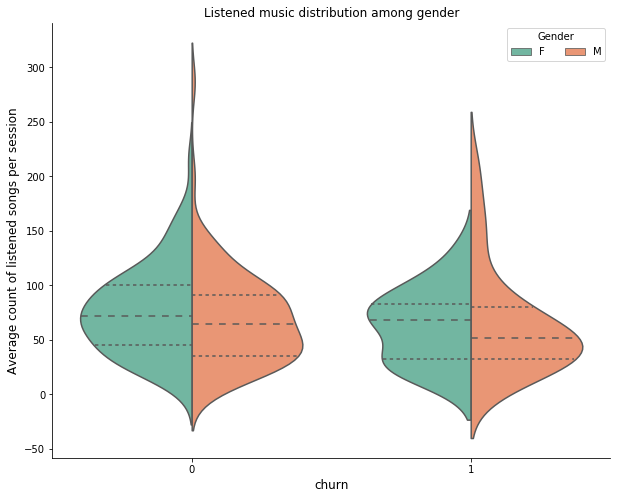

In [43]:
plt.figure(figsize=(10,8))
ax = sns.violinplot('churn', y = 'avg_songs_played', hue = 'gender', data = df_pandas_song, palette="Set2", split = True, inner="quartile")
plt.xlabel('churn', fontsize = 12)
plt.ylabel('Average count of listened songs per session', fontsize = 12)
plt.legend(title = 'Gender', loc = 'best', ncol = 2)
plt.title('Listened music distribution among gender')
sns.despine(ax=ax);

It is seen that churned users had listened less music than the others. And also churned female users average listened songs are more than males. 

###### Notes on Violin Plot

A violin plot plays a similar role as a box and whisker plot. It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. Unlike a box plot, in which all of the plot components correspond to actual datapoints, the violin plot features a kernel density estimation of the underlying distribution.

Violin plots have many of the same summary statistics as box plots:
* The white dot represents the median
* The thick gray bar in the center represents the interquartile range
* The thin gray line represents the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the interquartile range.

On each side of the gray line is a kernel density estimation to show the distribution shape of the data. Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.

[1] https://mode.com/blog/violin-plot-examples

[2] https://blog.bioturing.com/2018/05/16/5-reasons-you-should-use-a-violin-graph/

In [44]:
df_pandas_likes = df.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
df_pandas_likes = df_pandas_likes.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

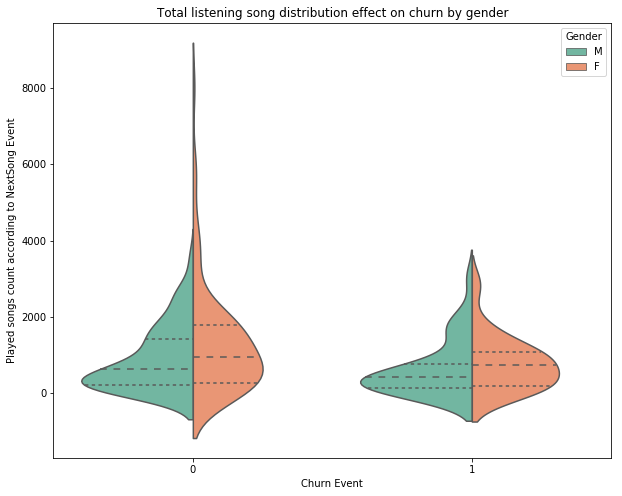

In [45]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(data = df_pandas_likes, x = 'churn', y = 'NextSong', hue = 'gender', split = True,  inner = "quartile", palette="Set2")
plt.xlabel('Churn Event')
plt.ylabel('Played songs count according to NextSong Event')
plt.legend(title = 'Gender', loc = 'best')
title = plt.title('Total listening song distribution effect on churn by gender')

It seems that the mean of the total listened songs do not change that much among churned and unchurned users. However, we can say that female users have larger mean value and distribution than the male users.

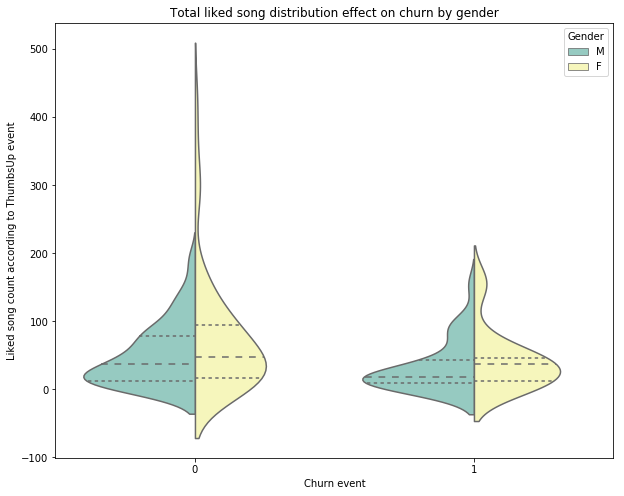

In [46]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(data = df_pandas_likes, x = 'churn', y = 'Thumbs Up', hue = 'gender', split = True,  inner = "quartile", palette="Set3")
plt.xlabel('Churn event')
plt.ylabel('Liked song count according to ThumbsUp event')
plt.legend(title='Gender', loc='best')
title = plt.title('Total liked song distribution effect on churn by gender')

Also for the liked song distribution, churned and normal users have similar characteristics.

###### Churned user status

It might me a good indicator to see which payment status of user had churned most.

In [47]:
df_pandas_level = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

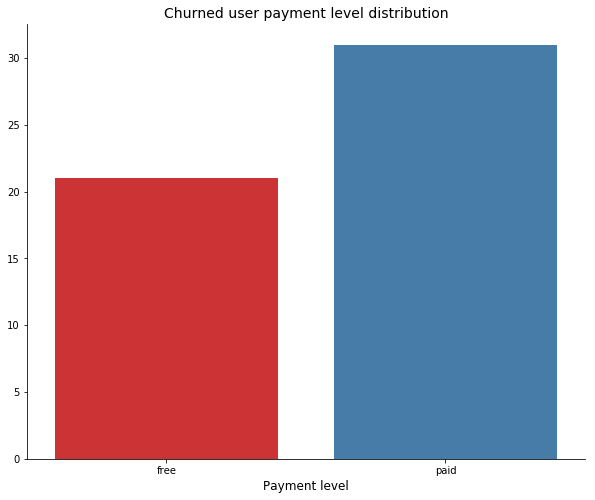

In [48]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data = df_pandas_level, x = 'level', y = 'count', palette="Set1")
plt.xlabel('Payment level', fontsize = 12)
plt.ylabel('')
plt.title('Churned user payment level distribution', fontsize = 14)
sns.despine(ax=ax);

It is seen that paid users had churned more than free users.

###### Page distribution

Let see the page distribution of churned and current users to understand the differences between them.

In [49]:
churned_user = df_pandas[df_pandas.churn == 1].groupby(['page'])['userId'].count()
churned_user = churned_user /churned_user.sum()*100

active_user = df_pandas[df_pandas.churn == 0].groupby(['page'])['userId'].count()
active_user = active_user /active_user.sum()*100

users_df = pd.DataFrame({'Cancelled': churned_user,'Active users':active_user})

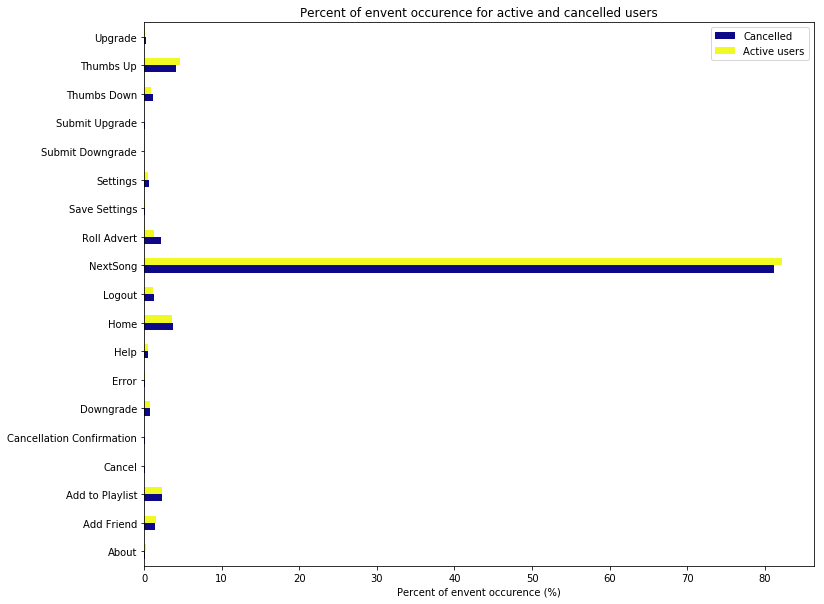

In [50]:
ax = users_df.plot(kind='barh', figsize=(12,10), cmap = "plasma");
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

Since Next Song creates a bias in the figure, I have decided to drop it.

In [51]:
churned_user = df_pandas[df_pandas.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
# Define percentage to visualize better
churned_user = churned_user /churned_user.sum()*100

active_user = df_pandas[df_pandas.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
# Define percentage to visualize better
active_user = active_user /active_user.sum()*100

users_df = pd.DataFrame({'Cancelled': churned_user,'Active users':active_user})

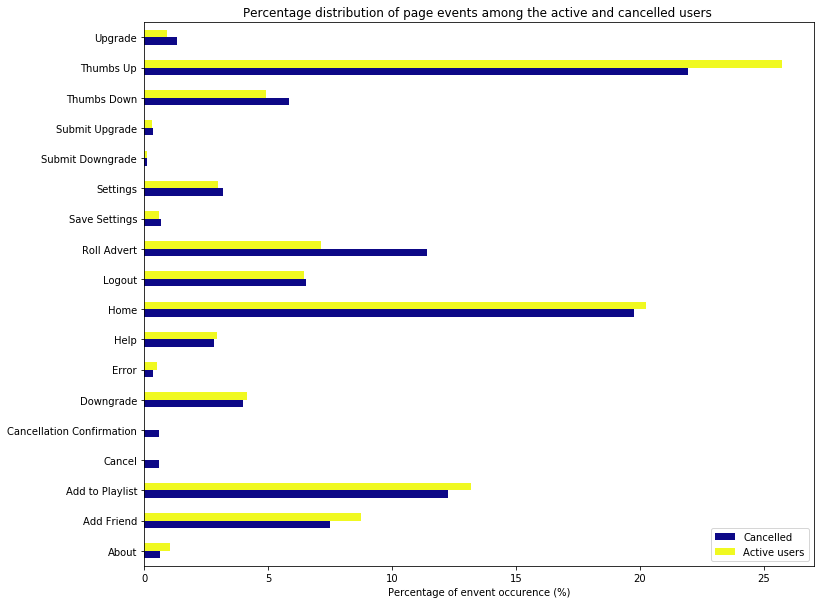

In [52]:
ax = users_df.plot(kind='barh', figsize=(12,10), cmap = "plasma");
ax.set_xlabel('Percentage of envent occurence (%)')
ax.set_title('Percentage distribution of page events among the active and cancelled users ');

##### Membership duration

Lastly, we can investigate the membership duration of users to see effect on churn event.

In [53]:
df_pandas_lifetime = df\
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df.ts-df.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

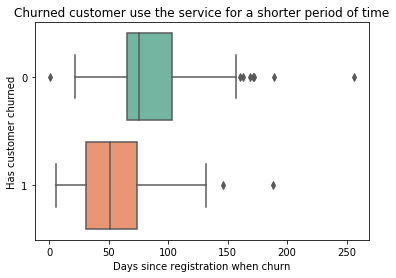

In [54]:
ax = sns.boxplot(data = df_pandas_lifetime, y = 'churn', x = 'lifetime', orient = 'h', palette = "Set2")
plt.xlabel('Days since registration when churn')
plt.ylabel('Has customer churned')
title = plt.title('Churned customer use the service for a shorter period of time')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

###### Dataset Features:
In the dataset, we have below features:

<u>Categorical features</u>
* Currently listening artists
* Authorization
* First/Last name of user
* Gender of user
* The payment level of membership (Paid/Free)
* Location
* Method
* Current page
* Currently listening song
* User agent, (MacOs, Windows, etc.)

<u>Numerical features</u>
* Item in session
* Length
* Registration date in timestamp format
* SessionId
* Status
* Time as ts in timestamp format
* Userid


For the analysis, we will add the below features according to the data exploration that we have performed in the previous section.

1. Gender feature as numerical/binary variable
2. Number of played/listened songs
3. Number of liked songs according to thumbs up/down
4. Number of songs added to playlist
5. Number of songs listened per session
6. Number of listened artists
7. Number of added friends.
8. Total time duration/lenght of listening event
9. Membership duration
10. Churn label
11. Downgrade label




In [55]:
# Gender feature as numerical/binary variable
feature_1 = df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
feature_1.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



In [56]:
# Number of played/listened songs
feature_2 = df.select('userID','song').groupBy('userID').count().withColumnRenamed('count', 'total_songs')
feature_2.show(5)

+------+-----------+
|userID|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
+------+-----------+
only showing top 5 rows



In [57]:
# Number of liked songs according to thumbs up/down
feature_3 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'thumbs_up')
feature_3.show(5)

+------+---------+
|userID|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
+------+---------+
only showing top 5 rows



In [58]:
# Number of liked songs according to thumbs up/down
feature_4 = df.select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'thumbs_down')
feature_4.show(5)

+------+-----------+
|userID|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows



In [59]:
# Number of songs added to playlist
feature_5 = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')
feature_5.show(5)

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
+------+---------------+
only showing top 5 rows



In [60]:
# Number of songs listened per session
feature_6 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
feature_6.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [61]:
# Number of listened artists
feature_7 = df.filter(df.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "artist_count")
feature_7.show(5)


+------+------------+
|userId|artist_count|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
+------+------------+
only showing top 5 rows



In [62]:
# Number of added friends
feature_8 = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'add_friend') 
feature_8.show(5)

+------+----------+
|userID|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows



In [63]:
# Total time duration/lenght of listening event
feature_9 = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')
feature_9.show(5)


+------+------------------+
|userID|       listen_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [64]:
# Membership duration
feature_10 = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId') \
    .agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
feature_10.show(5)

+------+------------------+
|userId|          lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [65]:
# Churn label
churn_label = df.select('userId', col('churn').alias('label')).dropDuplicates()
churn_label.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [66]:
# Downgrade label
downgrade_label = df.select('userId', col('downgrade').alias('downgrade_label')).dropDuplicates()
downgrade_label.show(5)

+------+---------------+
|userId|downgrade_label|
+------+---------------+
|100010|              0|
|200002|              0|
|   125|              0|
|   124|              0|
|    51|              0|
+------+---------------+
only showing top 5 rows



In [67]:
data = feature_1.join(feature_2,'userID','outer') \
    .join(feature_3,'userID','outer') \
    .join(feature_4,'userID','outer') \
    .join(feature_5,'userID','outer') \
    .join(feature_6,'userID','outer') \
    .join(feature_7,'userID','outer') \
    .join(feature_8,'userID','outer') \
    .join(feature_9,'userID','outer') \
    .join(feature_10,'userID','outer') \
    .join(churn_label,'userID','outer') \
    .join(downgrade_label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------+-----------+---------+-----------+---------------+------------------+------------+----------+------------------+------------------+-----+---------------+
|gender|total_songs|thumbs_up|thumbs_down|add_to_playlist|  avg_songs_played|artist_count|add_friend|       listen_time|          lifetime|label|downgrade_label|
+------+-----------+---------+-----------+---------------+------------------+------------+----------+------------------+------------------+-----+---------------+
|     1|        381|       17|          5|              7|39.285714285714285|         252|         4| 66940.89735000003|  55.6436574074074|    0|              0|
|     0|        474|       21|          6|              8|              64.5|         339|         4| 94008.87593999993| 70.07462962962963|    0|              0|
|     0|         11|        0|          0|              0|               8.0|           8|         0|2089.1131000000005| 71.31688657407408|    1|              0|
|     1|       4825|      17

In [68]:
# Saving as SPARK format
data.write.save('SparkFile_10.CSV', format='csv', header=True)

In [69]:
data_pandas = data.toPandas()
data_pandas.head(10)

,gender,total_songs,thumbs_up,thumbs_down,add_to_playlist,avg_songs_played,artist_count,add_friend,listen_time,lifetime,label,downgrade_label
0,1,381,17,5,7,39.285714,252,4,6.694090e+04,55.643657,0,0
1,0,474,21,6,8,64.500000,339,4,9.400888e+04,70.074630,0,0
2,0,11,0,0,0,8.000000,8,0,2.089113e+03,71.316887,1,0
3,1,4825,171,41,118,145.678571,2232,74,1.012312e+06,131.555914,0,0
4,0,2464,100,21,52,211.100000,1385,28,5.232758e+05,19.455845,1,0
5,0,201,7,1,5,21.428571,142,1,3.803409e+04,72.778183,0,0
6,0,2278,81,14,59,136.714286,1302,31,4.773076e+05,56.513576,0,0
7,1,3437,163,29,72,81.171429,1744,33,7.113449e+05,110.751690,1,1
8,1,1002,58,3,24,136.666667,643,11,1.987793e+05,23.556019,0,0
9,0,310,17,3,7,42.833333,233,6,6.770347e+04,85.083403,1,0


In [70]:
data_pandas.to_csv('PandasFile_71.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize. 

##### Notes on F1 Score

According to Wikipedia, F1 Score is defined as a weighted average of the precision and recall where an F1 score reached its best value at 1 and worst at 0. But first lets define the precision and recall:

* The precision is the number of correct positive results divided by the number of all positive results. Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive. Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection. In email spam detection, a false positive means that an email that is non-spam (actual negative) has been identified as spam (predicted spam). The email user might lose important emails if the precision is not high for the spam detection model.

* The recall is the number of correct positive results divided by the number of positive results that should have been returned. Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


And accuracy is one of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.

F1 Score is defined as the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric. And the use case differences of accuracy and F1 Score can be summarized as below:

1. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial

2. Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.

3. In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.


[1] https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

[2] https://adamyedidia.files.wordpress.com/2014/11/f_score.pdf

[3] https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2

In [71]:
data_pandas.columns

Index(['gender', 'total_songs', 'thumbs_up', 'thumbs_down', 'add_to_playlist',
       'avg_songs_played', 'artist_count', 'add_friend', 'listen_time',
       'lifetime', 'label', 'downgrade_label'],
      dtype='object')

We will use the saved features as the inputs except the churn event, indicated as label. Because the churn label will be the feature that we want to predict by using the related features.

After defining the features, we will create the feature vector and perform transformation.

In [72]:
# The input features are all features except the Churn Label and the output is the churn event.

features_labels = ['gender', 'total_songs', 'thumbs_up', 'thumbs_down', 'add_to_playlist',
                   'avg_songs_played', 'artist_count', 'add_friend', 'listen_time', 'lifetime', 'downgrade_label' ]

# Define the vector assembler for all input columns
features_vector  = VectorAssembler(inputCols = features_labels, outputCol = "features")

input_data = features_vector.transform(data)

As a next step, we will perform standardization. Standardization is performed because using these variables without standardization in effect gives the variable with the larger range a weight of 100 in the analysis. Typical data standardization procedures equalize the range and/or data variability. Therefore we standardize the features by taking off the mean and divided by the standard deviation of each feature.

[1] https://spark.apache.org/docs/latest/ml-features

[2] https://scikit-learn.org/stable/modules/preprocessing.html

In [73]:
# standard scaler
features_scaler = StandardScaler(inputCol = "features", outputCol="scaled_features", withMean=True)
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

After standardize our features, we can divide our dataset in to test, train, and validation. We can use randomSplit function to divide our dataset. 

RandomSplit is performing the randomly splits this DataFrame with the provided weights. When we perform random splitting we are splitting the data randomly to generate two sets: one to use during training of the ML algorithm (training set), and the second to check whether the training is working (test set). This is widely done and a very good idea, as it catches overfitting which otherwise can make it seem like you have a great ML solution when it's actually effectively just memorized the answer for each data point and can't interpolate or generalize.

And one of the main problem is selecting the seed which is defined according to reference 4.

[1] https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html

[2] https://stackoverflow.com/questions/40606456/randomsplit-dont-respect-specific-weights-pyspark

[3] https://stackoverflow.com/questions/24857650/issue-understanding-splitting-data-in-scala-using-randomsplit-for-machine-lear

[4] https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

In [74]:
# Creating train, test, and validation
train, rest = scaled_inputs.randomSplit([0.8, 0.2], seed = 45)
validation, test = rest.randomSplit([0.5, 0.5], seed = 45)

Use baseline model to observe accuracy and F1-Score.

In [75]:
results_1 = test.withColumn('prediction', lit(1.0))

In [76]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.20588235294117646
F-1 Score:0.07030129124820661


In [77]:
results_0 = test.withColumn('prediction', lit(0.0))

In [78]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.7941176470588235
F-1 Score:0.7029893924783028


As a next step, we will perform classification with different algorithms to observe the result. 

[1] https://spark.apache.org/docs/latest/ml-classification-regression.html

##### Gradient Boost and Random Forest


The idea of boosting came out of the idea of whether a weak learner can be modified to become better. A weak hypothesis or weak learner is defined as one whose performance is at least slightly better than random chance.
Gradient Boost Trees is the modified and improved version of AdaBoost. 

AdaBoost, which is the abbreviation of the Adaptive Boosting, is the first practical boosting algorithm proposed by Freund and Schapire in 1996. AdaBoost is an algorithm for constructing a “strong” classifier as linear combination of “simple” “weak” classifier. In other words, the main working principle is to convert a set of weak classifiers into a strong one. Weak classifier is described as less than 50% error over any distribution and strong classifier is thresholded linear combination of the weak classifier outputs. AdaBoost works by weighting the observations, putting more weight on difficult to classify instances and less on those already handled well. New weak learners are added sequentially that focus their training on the more difficult patterns. Predictions are made by majority vote of the weak learners’ predictions, weighted by their individual accuracy. 

Gradient boosting involves three elements:
* A loss function to be optimized. The loss function used depends on the type of problem being solved. It must be differentiable, but many standard loss functions are supported and you can define your own. For example, regression may use a squared error and classification may use logarithmic loss
* A weak learner to make predictions. Decision trees are used as the weak learner in gradient boosting
* An additive model to add weak learners to minimize the loss function. Trees are added one at a time, and existing trees in the model are not changed. A gradient descent procedure is used to minimize the loss when adding trees.

GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree. A great application of GBM is anomaly detection in supervised learning settings where data is often highly unbalanced such as DNA sequences, credit card transactions or cybersecurity.

The differences between the GBT and RF can be explained as Gradient boosting uses regression trees for prediction purpose where a random forest use decision tree. ... The random forest is easy to parallelize but boosted trees are hard to do. Random forests overfit a sample of the training data and then reduces the overfit by simple averaging the predictors. If you carefully tune parameters, gradient boosting can result in better performance than random forests. However, gradient boosting may not be a good choice if you have a lot of noise, as it can result in overfitting. They also tend to be harder to tune than random forests.

[1] https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

[2] https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80

[3] https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained

In [79]:
# initialize the GBT classifier
gbt = GBTClassifier(maxIter = 10, seed = 45)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

gbt_crossvalidation = CrossValidator(estimator = gbt,
                                    estimatorParamMaps = paramGrid,
                                    evaluator = f1_evaluator,
                                    numFolds = 3)

Fit the training data:

In [80]:
start = time()
cvModel_gbt = gbt_crossvalidation.fit(train)
end = time()
cvModel_gbt.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 1140.1361155509949 seconds


In [81]:
gbt_result = cvModel_gbt.transform(validation)

In [90]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(gbt_result, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(gbt_result, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.8333333333333334
F-1 Score:0.838095238095238


In [91]:
# initialize the random forest classifier
randomforest = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

randomforest_crossval = CrossValidator(estimator = randomforest,
                              estimatorParamMaps = paramGrid,
                              evaluator = f1_evaluator,
                              numFolds = 3)

In [92]:
start = time()
cvModel_rf = randomforest_crossval.fit(train)
end = time()
cvModel_rf.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 520.41619181633 seconds


In [93]:
randomforest_result = cvModel_rf.transform(validation)

In [94]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(randomforest_result, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(randomforest_result, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 1.0
F-1 Score:1.0


##### Support Vector Machines
The working principle of the support vector machines is to find or create the hyperplane in an N-dimensional space that distinctly classifies the data points. The dimension of the hyperplane is depending on the number of the features. Hyperplanes are basicly the desicion boundaries that helps the classification of the data such that data points which are locating at te different side of the hyperplane are classified as different classes. Support vector machines are commonly used in face detection, text and hypertext categorization, classification of images, bioinformatics and, handwriting recognition. One of the real world example is performed in the article "Application of support vector machine modeling for prediction of common diseases: the case of diabetes and pre-diabetes".


In [95]:
# initialize classifier
svm = LinearSVC(maxIter = 10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

svm_crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [96]:
start = time()
cvModel_svm = svm_crossval.fit(train)
end = time()
cvModel_svm.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 709.1884164810181 seconds


In [97]:
svm_result = cvModel_svm.transform(validation)

In [98]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(svm_result, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(svm_result, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.6666666666666666
F-1 Score:0.5333333333333333


##### Decision Tree Classifier

In decision analysis, one of the visual and explicit representation of decision and decision making procedure can be performed by using decision trees. The decision tree is using a tree-like model of decisions such that a flowchart like tree structure in which each node internal node denotes a test and each branch represents an outcome of the test and each leaf node holds a corresponding class label. Decision tree is the one of the most powerfull and popular tool for classification and prediction. Decision trees are commonly using in medical diagnosis, failure prediction, credit scroing and crime risk investigation. Several business analysis examples can be found but one of the widely used one is the detection of the raudulent Financial Statements.

In [99]:
dt = DecisionTreeClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

dt_crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [100]:
start = time()
cvModel_dt = dt_crossval.fit(train)
end = time()
cvModel_dt.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 595.8720190525055 seconds


In [101]:
dt_result = cvModel_dt.transform(validation)

In [102]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Decision Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(dt_result, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(dt_result, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.8333333333333334
F-1 Score:0.838095238095238


#### Model Comparision and Decision

Gradient Boost Trees, Random Forest, Support Vector Machines, and Decision Tree algorithms are selected and used for training. Below is the summary of obtained accuracy, F1 Score during a recorded training time
* **Gradient Boost Trees** gave the accuracy of **0.833**, F1 Score of **0.830** with **1140.13 secs** of training duration.

* **Random Forest** gave the accuracy of **1.00**, F1 Score of **1.00** with **520.41 secs** of training duration.

* **Support Vector Machines** gave the accuracy of **0.666**, F1 Score of **0.5333** with **709.8 secs** of training duration.

* **Decision Trees** gave the accuracy of **0.833**, F1 Score of **0.830** with **595.87 secs** of training duration.

Since the accuracy and F1 Score are the most important results for selecting the algorithm, training duration time has also an effect while working with large dataset. Since we have a relatively small dataset, I will choose the GBT algorithm because it has the 0.833% accuracy and I will try to improve GBT algorithm result with hyperparameter tuning to obtain the best model. 

Note: Random Forest algorithm provides 1.0 accuracy and F1 results which is interesting and can be sign of overfitting.


##### Model Tuning

In [105]:
GBTClassifier(maxIter = 10, seed = 45)

# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.maxIter, [10,15]) \
    .build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

gbt_crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [ ]:
start = time()
cvModel_gbt = gbt_crossval.fit(train)
end = time()
cvModel_gbt.avgMetrics
print('The training process took {} seconds'.format(end - start))

In [ ]:
best_model = GBTClassifier(maxIter=10,seed=45, maxDepth=5)
best_model = best_model.fit(train)
results = best_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Best Model Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

##### Feature Importance Observation

### Conclusion

The machine learning modeling has a success in predicting the customer's churn activity. That can help the application owners to improve the user lifetime. Despite the relatively good results of other selected machine learning models such as SVM and Decision Trees, the GBT algorithm is selected and tuned with hyperparameters. For a future work, the Random Forest algorithm can be adjusted with different settings to overcome the over-fitting.

###### Possible Improvements for Current Model
Even if we have more than 80% accuracy in current model, there is still a chance to improve it by 
* Working with more observations by increasing the dataset size.
* Investigating the different parameter settings to have more accuracy.
* Analyzing location information effect on the churned user since location can provide us a information about life style and give company owner a chance to provide location based promotions to keep the users.
* Used environment can also provide a usefull information. If android users are more likely to churned, this means the application needs an improvement for that environment.




# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.